# Imports and Loading Data

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# NOTE: These numbers in the brackets do no match the citations in Overleaf right now because it keeps changing.

# [1] Centers for Disease Control and Prevention. Behavioral Risk Factor Surveillance System (BRFSS)
# I think this is way too cumbersome to use, if someone wants to take a second look feel free.
# df1 = pd.read_sas('LLCP2023.XPT', format='xport', encoding='utf-8')

# [2] SVI Data (CDC/ATSDR Social Vulnerability Index)
df2 = pd.read_csv("SVI_2022_US_county.csv", encoding="latin1")

# [3] National Center for Health Statistics. Provisional Drug Overdose Death Counts.
df3 = pd.read_csv("VSRR_Provisional_Drug_Overdose_Death_Counts.csv", encoding="ISO-8859-1")

# [4] Craig Chilvers. US Drug Overdose EDA and Visualisation.
df4 = pd.read_csv("CDC Injury Center Drug Overdose Deaths.csv", encoding="latin1")

# [5] Substance Abuse and Mental Health Services Administration. National Survey on Drug Use and Health (NSDUH)
df5 = pd.read_csv("Drug Overdose.csv", encoding="latin1")

# Load state abbreviation reference
state_abbrev = pd.read_csv("https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv")
state_abbrev = state_abbrev.rename(columns={"State": "STATE_NAME", "Abbreviation": "STATE_ABBR"})

# Cleaning and preparing SVI data

In [11]:

df2["STATE"] = df2["STATE"].str.strip()

# Merge in state abbreviations so we can aggregate them later
df2_state = df2.merge(state_abbrev, how="left", left_on="STATE", right_on="STATE_NAME")

# Group county-level data to the state level
svi_state = df2_state.groupby("STATE_ABBR")[[
    "EP_POV150", "EP_UNEMP", "EP_NOHSDP", "EP_UNINSUR", "RPL_THEMES"
]].mean().reset_index()

svi_state.rename(columns={
    "EP_POV150": "PercentBelow150Poverty",
    "EP_UNEMP": "UnemploymentRate",
    "EP_NOHSDP": "PercentWithoutHS",
    "EP_UNINSUR": "PercentUninsured",
    "RPL_THEMES": "SVI_IndexScore"
}, inplace=True)



# Cleaning and preparing overdose dataset (VSRR)

In [14]:
# Stripping whitespace
df3 = df3.rename(columns=lambda x: x.strip())

# Renaming relevant columns we're going to keep
df3_slim = df3[["State Name", "Year", "Data Value"]].dropna()
df3_slim = df3_slim.rename(columns={"State Name": "STATE_NAME", "Data Value": "Overdose_Rate"})

# Adding the state abbreviations so we can merge with SVI set
df3_slim = df3_slim.merge(state_abbrev, how="left", on="STATE_NAME")

# Merging

In [17]:
df_merged = df3_slim.merge(svi_state, how="left", on="STATE_ABBR")

# Tidying up the merged dataset

# Fixing string overdose rates
df_merged["Overdose_Rate"] = (
    df_merged["Overdose_Rate"]
    .astype(str)
    .str.replace(",", "")
    .astype(float)
)

# Dropping rows without state information
df_merged = df_merged.dropna(subset=["STATE_ABBR"])

# Dropping suplicates
df_merged = df_merged.drop_duplicates()

# Aggregate merged data by state and year
df_merged_grouped = df_merged.groupby(["STATE_ABBR", "Year"], as_index=False).agg({
    "Overdose_Rate": "mean",
    "PercentBelow150Poverty": "mean",
    "UnemploymentRate": "mean",
    "PercentWithoutHS": "mean",
    "PercentUninsured": "mean",
    "SVI_IndexScore": "mean"
})


# Rename columns to more descriptive names
df_merged_grouped.rename(columns={
    "STATE_ABBR": "State",
    "Overdose_Rate": "OverdoseRatePer100k",
    "EP_POV150": "PercentBelow150Poverty",
    "EP_UNEMP": "UnemploymentRate",
    "EP_NOHSDP": "PercentWithoutHS",
    "EP_UNINSUR": "PercentUninsured",
    "RPL_THEMES": "SVI_IndexScore"
}, inplace=True)

# Adding df4 to the merged set

rate_cols = [col for col in df4.columns if "Age-adjusted Rate" in col]

# "Melting" the dataframe to long format so we can merge
df4_melted = df4.melt(
    id_vars=["State", "State Abbreviation"],
    value_vars=rate_cols,
    var_name="Metric",
    value_name="OverdoseRate_alt"
)

# Extracting the year from the column name
df4_melted["Year"] = df4_melted["Metric"].str.extract(r"(\d{4})").astype(int)

# Had to remove the extra State column
df4_melted.drop(columns=["State"], inplace=True)

# Renamed 'State Abbreviation' to 'State' so it matched the merged set
df4_melted.rename(columns={"State Abbreviation": "State"}, inplace=True)

# Final format before we merge
df4_melted = df4_melted[["State", "Year", "OverdoseRate_alt"]]

# Merge with the existing merged dataset
df_final = df_merged_grouped.merge(df4_melted, on=["State", "Year"], how="left")

# Cleaning df5 so its ready for visualization

In [20]:

df5_clean = df5[
    (df5["AGE"] == "All ages") &
    (df5["STUB_NAME"] == "Total") &
    (df5["STUB_LABEL"] == "All persons") &
    (df5["PANEL"] == "All drug overdose deaths")
]

df5_clean = df5_clean[["YEAR", "AGE", "ESTIMATE"]].rename(columns={
    "YEAR": "Year",
    "AGE": "AgeGroup",
    "ESTIMATE": "OverdoseRatePer100k"
})

df5_clean = df5_clean.sort_values("Year")

df5_clean_again = (
    df5_clean
    .groupby(["Year", "AgeGroup"], as_index=False)
    .agg({"OverdoseRatePer100k": "mean"})
    .sort_values("Year")
)


# Make csv files of the final set and the cleaned intermediate sets so team can use

In [23]:
# The main dataset we’ll use. It combines:
# - State-level social vulnerability info (from the SVI data)
# - Overdose death rates (from the VSRR dataset)
# - Age-adjusted overdose rates (from the Chilvers/CDC dataset)
df_final.to_csv("final.csv", index=False)

# SVI data cleaned and averaged by state.
# Includes things like poverty %, unemployment %, uninsured %, etc.
svi_state.to_csv("svi_state_cleaned.csv", index=False)

# Cleaned overdose death rates by state and year from the VSRR dataset.
# This is one of our main sources for overdose rates.
df3_slim.to_csv("overdose_vsrr_cleaned.csv", index=False)

# Cleaned version of the Chilvers/CDC dataset.
# Gives us another view of age-adjusted overdose rates by state and year.
df4_melted.to_csv("cdc_overdose_alt_cleaned.csv", index=False)

# National overdose trends from the NSDUH survey.
# Just shows rates per year (no state info), useful for high-level trends, easy to visualize.
df5_clean_again.to_csv("national_overdose_trends_clean.csv", index=False)


In [25]:


df = pd.read_csv("final.csv")

df.describe()


,Year,OverdoseRatePer100k,PercentBelow150Poverty,UnemploymentRate,PercentWithoutHS,PercentUninsured,SVI_IndexScore,OverdoseRate_alt
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,252.000000
mean,2019.500000,10323.744170,22.451371,5.114256,10.482327,8.397742,0.486100,21.327381
std,2.875101,15389.535684,4.999090,1.254485,3.100337,3.271932,0.181356,9.666239
min,2015.000000,608.950539,14.180000,2.315054,6.292857,3.014286,0.206050,6.400000
25%,2017.000000,2527.959518,18.965657,4.160000,7.742857,6.077108,0.334660,13.950000
50%,2019.500000,5626.810631,21.005882,5.352239,9.500000,7.828125,0.471745,19.350000
75%,2022.000000,10564.376759,26.005217,5.905970,13.243636,10.784783,0.671028,26.725000
max,2024.000000,92396.562777,34.965854,7.893333,17.050787,17.414173,0.829213,57.800000


# Visualizing 


In [11]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)


In [13]:

scaling_factor = (
    df[df["OverdoseRate_alt"].notnull()]["OverdoseRatePer100k"].median()
    / df[df["OverdoseRate_alt"].notnull()]["OverdoseRate_alt"].median()
)


df["OverdoseRatePer100k_adj"] = df["OverdoseRatePer100k"] / scaling_factor


# Histogram

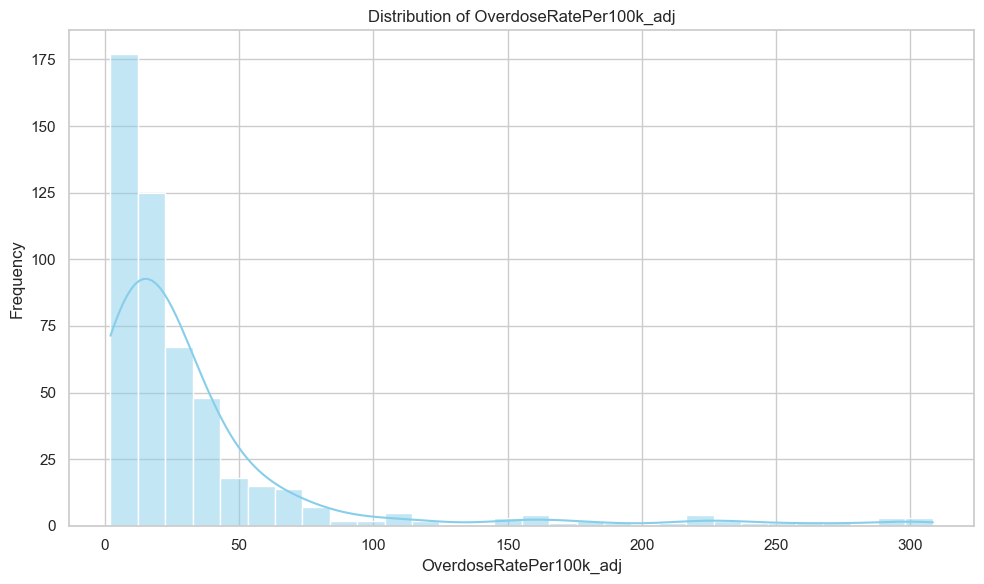

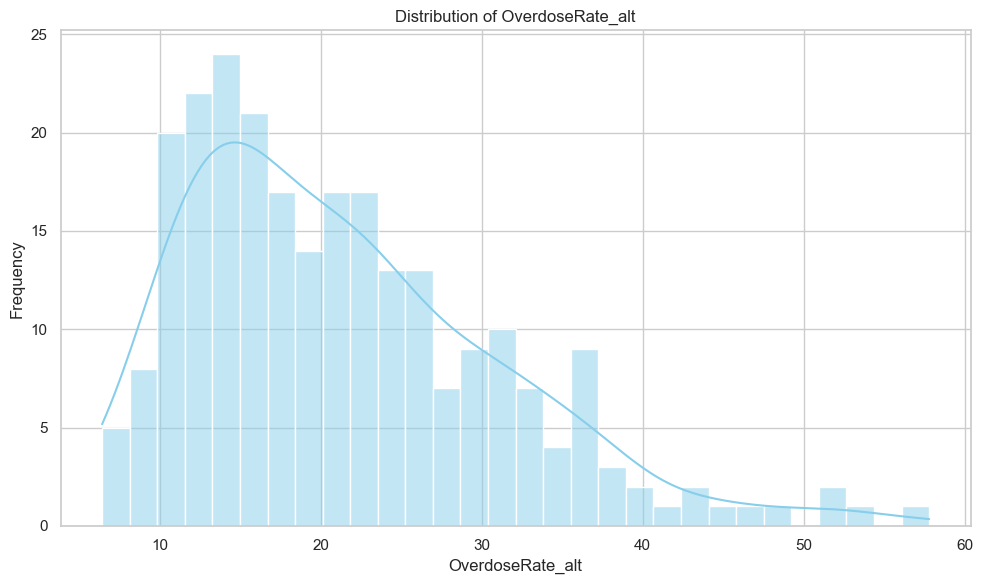

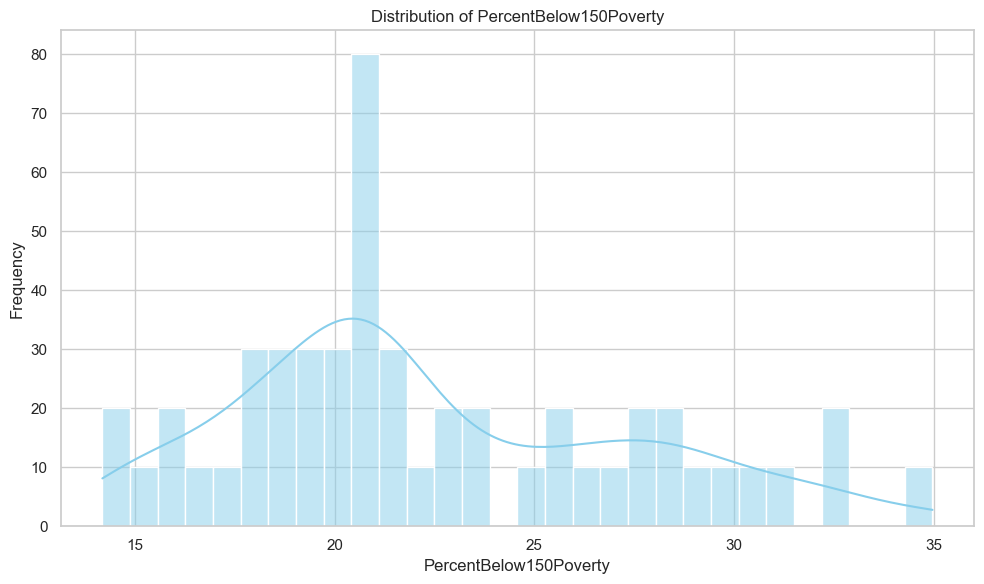

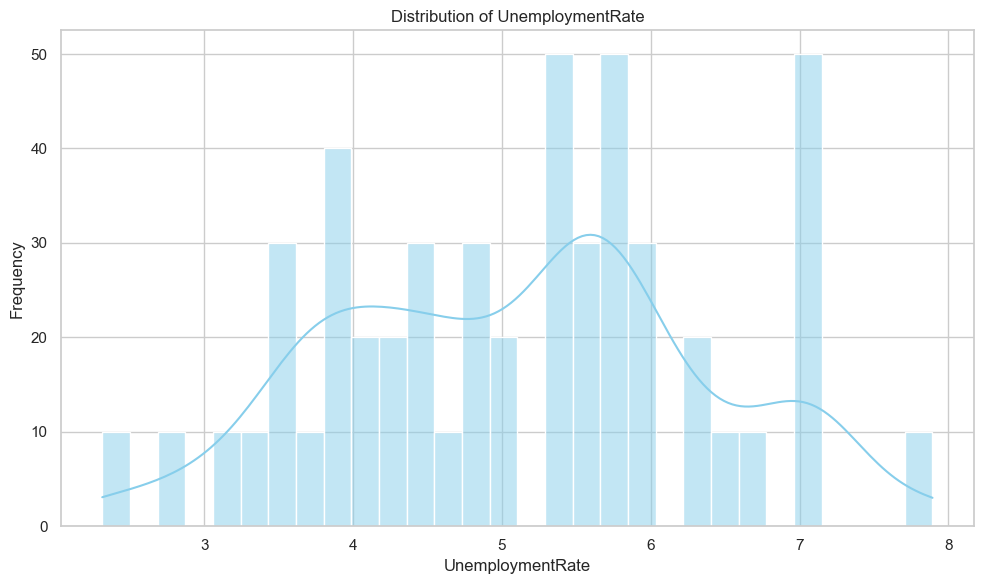

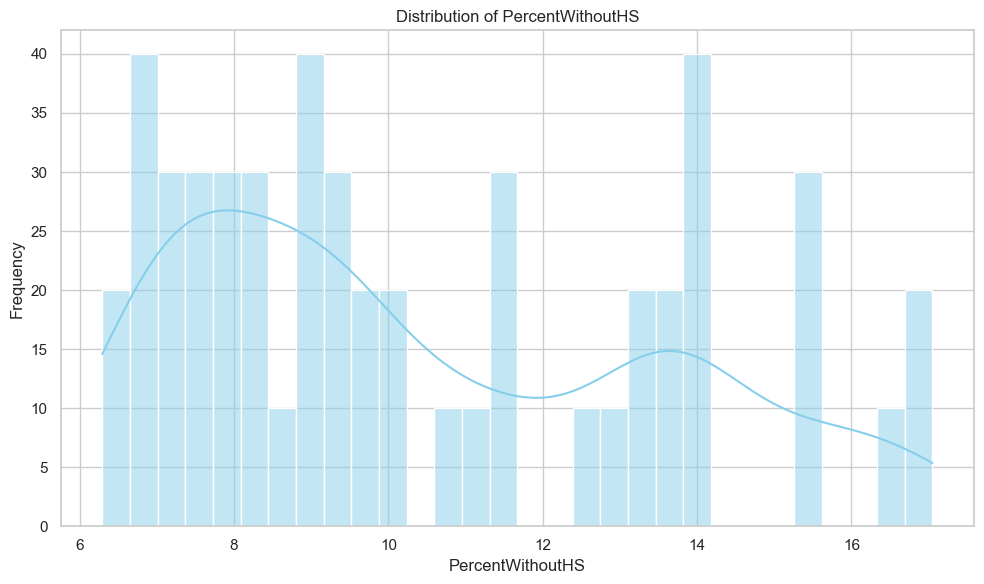

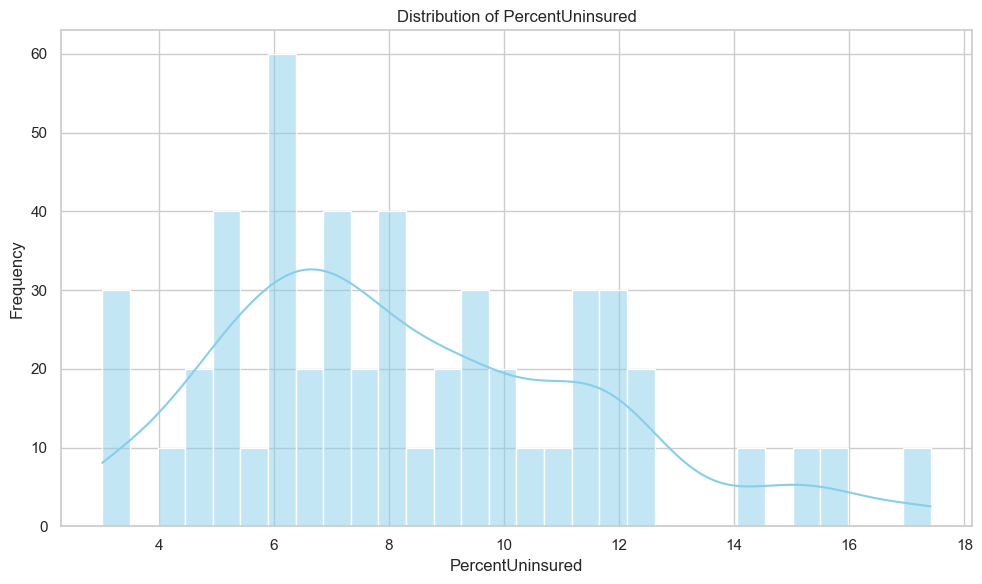

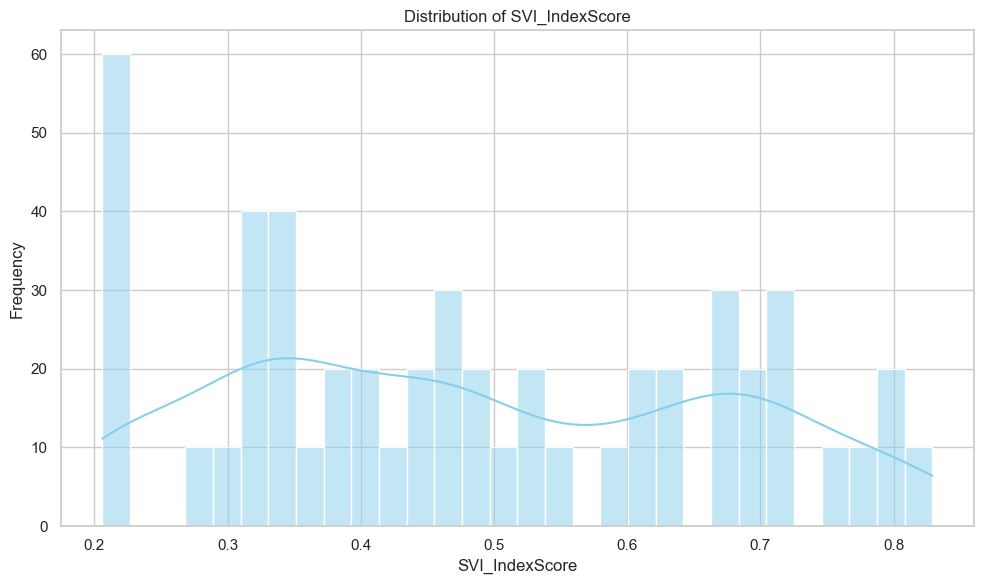

In [14]:
numeric_cols = [
    "OverdoseRatePer100k_adj", "OverdoseRate_alt",
    "PercentBelow150Poverty", "UnemploymentRate",
    "PercentWithoutHS", "PercentUninsured", "SVI_IndexScore"
]

for col in numeric_cols:
    sns.histplot(df[col], bins=30, kde=True, color="skyblue")
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


# BoxPlots-Variability & Outliers

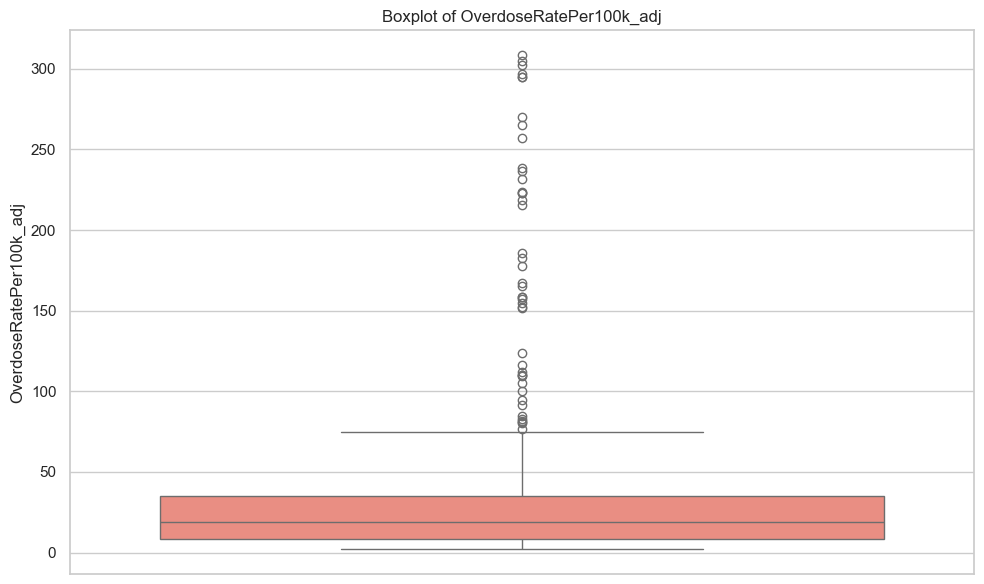

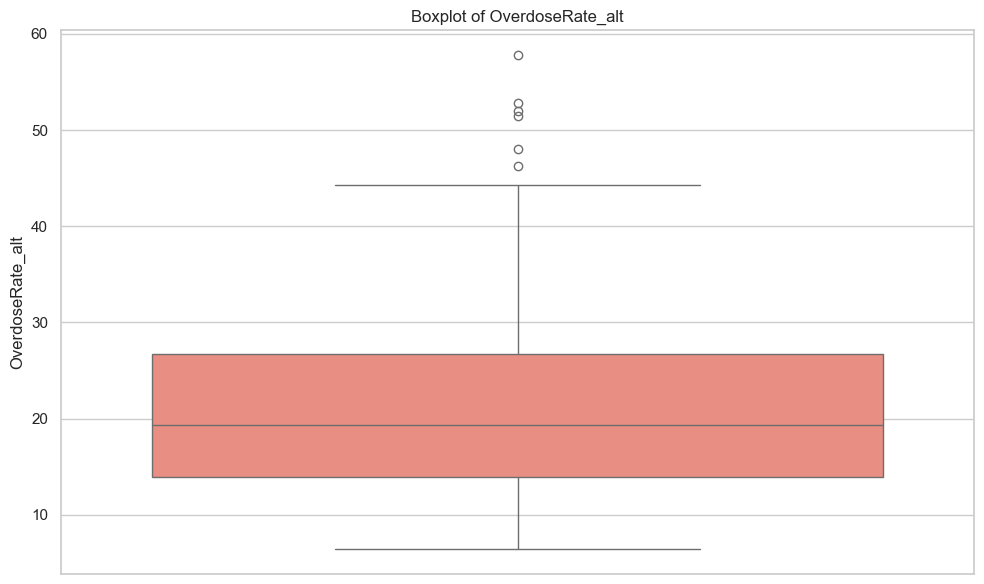

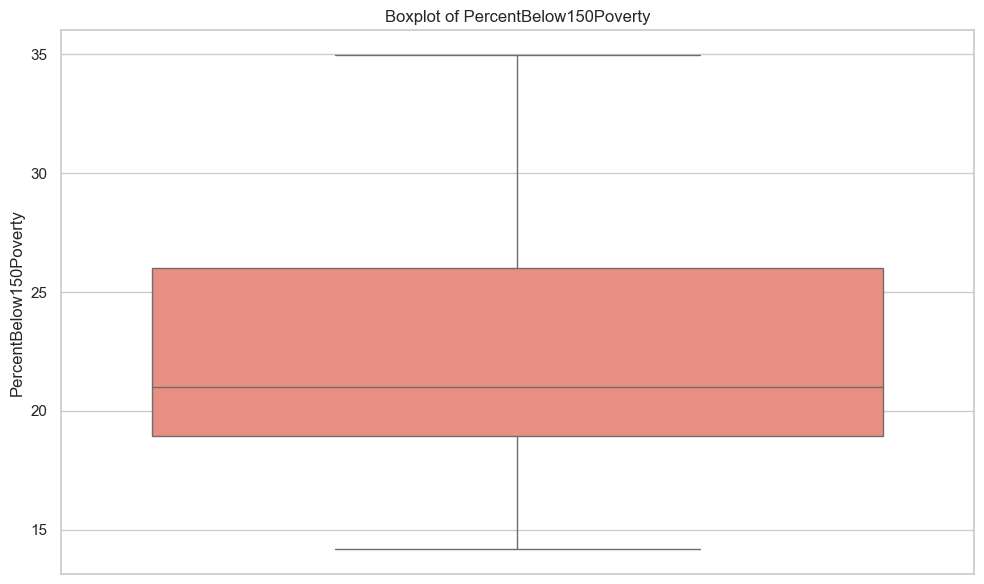

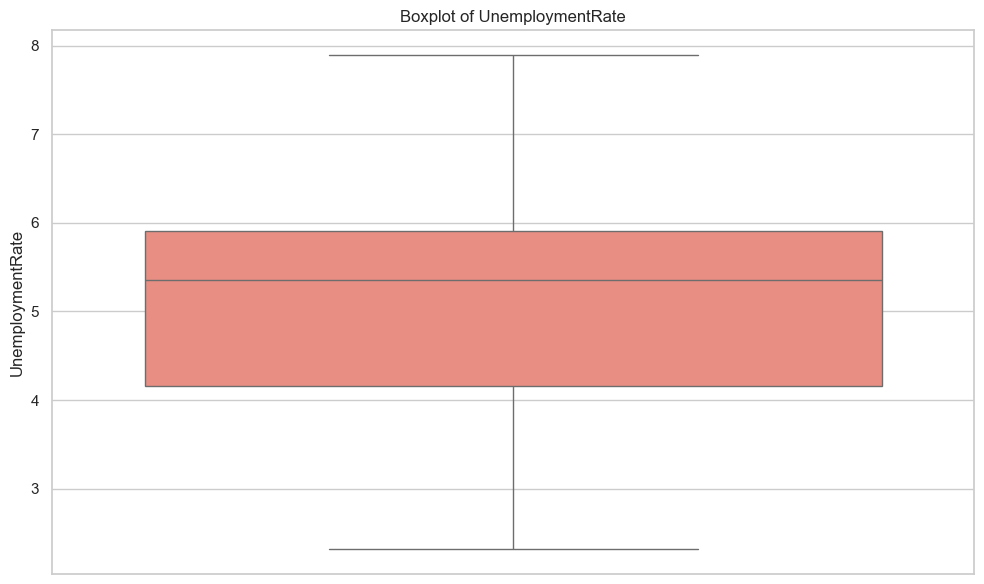

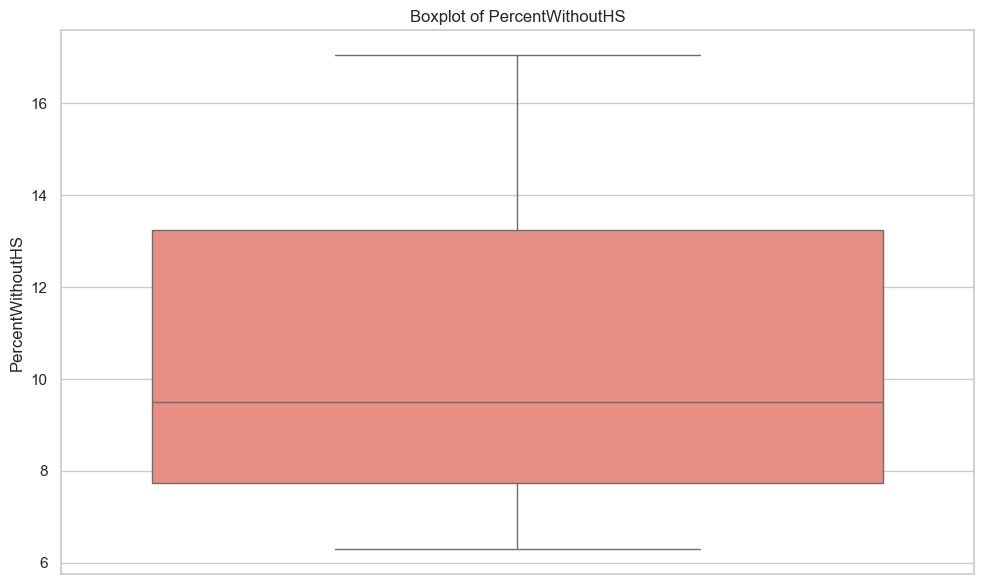

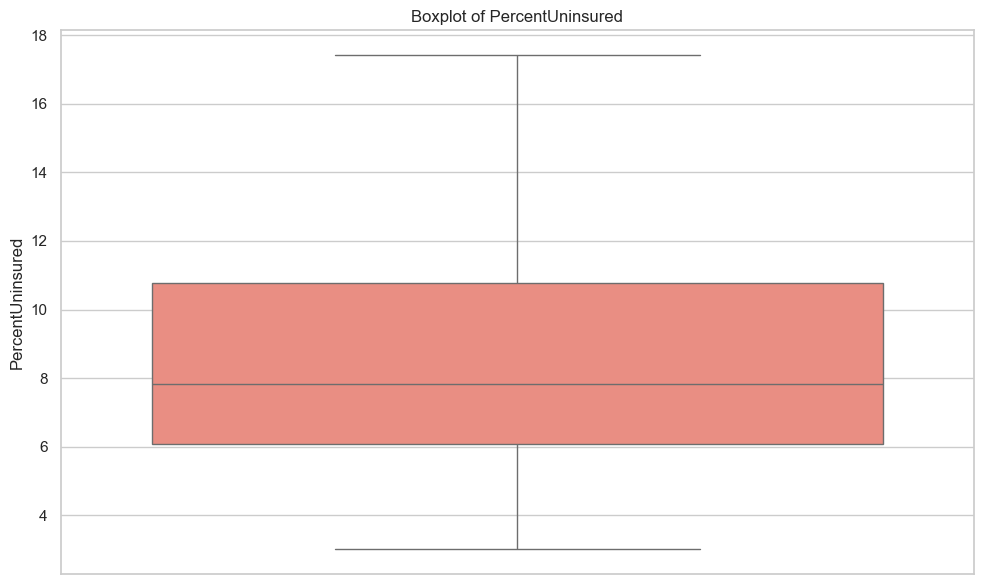

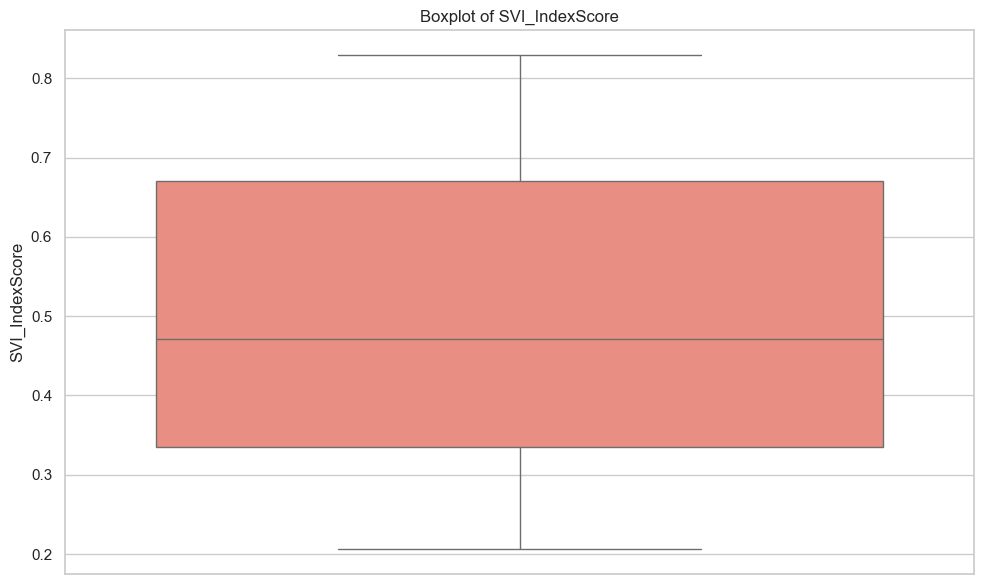

In [15]:
for col in numeric_cols:
    sns.boxplot(y=df[col], color="salmon")
    plt.title(f"Boxplot of {col}")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


# Bar Chat- Mean overdoses per year

/tmp/ipykernel_2141874/1513022444.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Year", y="OverdoseRatePer100k_adj", data=df_yearly, palette="viridis")


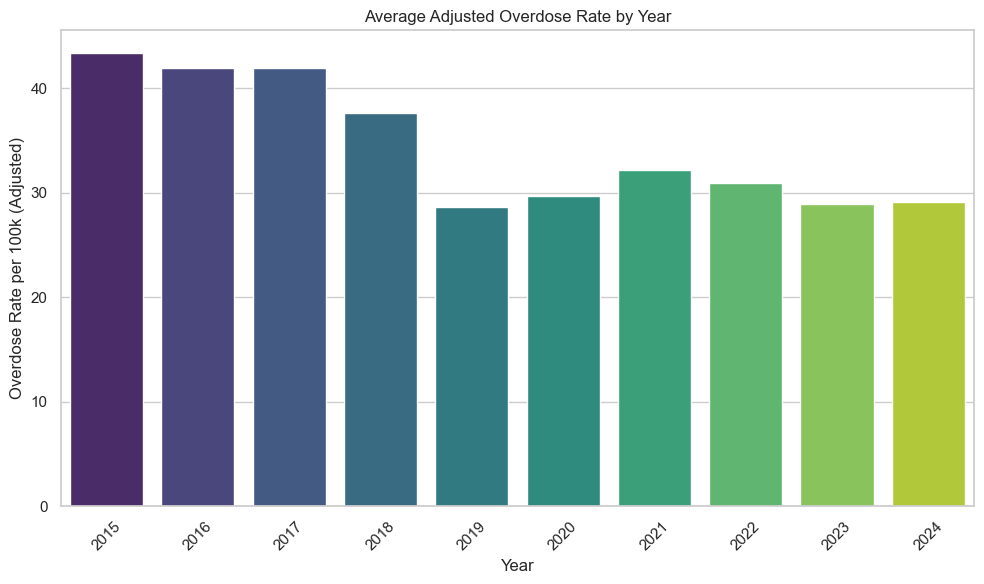

<Figure size 1000x600 with 0 Axes>

In [26]:
df_yearly = df.groupby("Year")["OverdoseRatePer100k_adj"].mean().reset_index()

sns.barplot(x="Year", y="OverdoseRatePer100k_adj", data=df_yearly, palette="viridis")
plt.title("Average Adjusted Overdose Rate by Year")
plt.ylabel("Overdose Rate per 100k (Adjusted)")
plt.xlabel("Year")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


plt.savefig('avg_adjusted_overdose_rate_by_year.png')


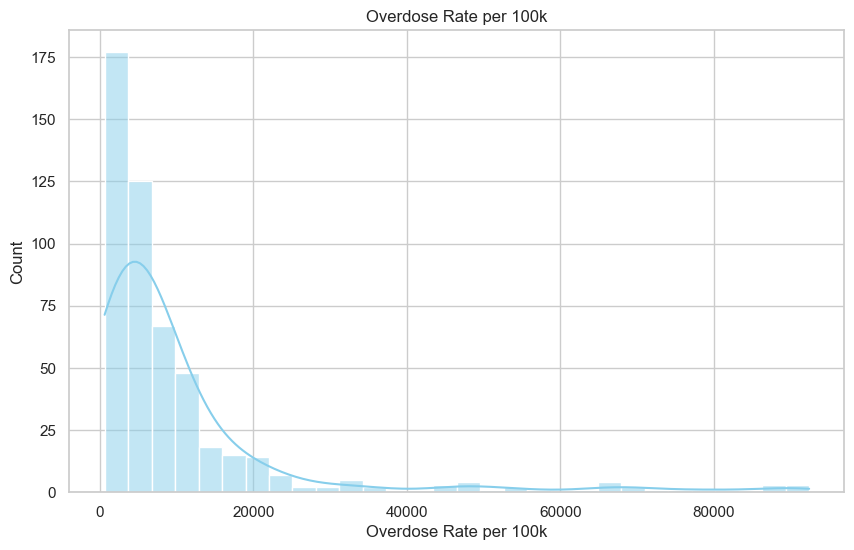

In [21]:


sns.histplot(df['OverdoseRatePer100k'], bins=30, kde=True, color="skyblue")
plt.title("Overdose Rate per 100k")
plt.xlabel("Overdose Rate per 100k")

plt.savefig('overdose_rate_per_100k_histogram.png', format='png')

plt.show()


In [ ]:
sns.scatterplot(x="UnemploymentRate", y="OverdoseRatePer100k", data=df)
plt.title("Overdose Rate vs Unemployment Rate")
plt.xlabel("Unemployment Rate")
plt.ylabel("Overdose Rate per 100k")

plt.savefig('overdose_vs_unemployment_scatter.png', format='png')

plt.show()


# Boxplot: Overdose by SVI Terciles

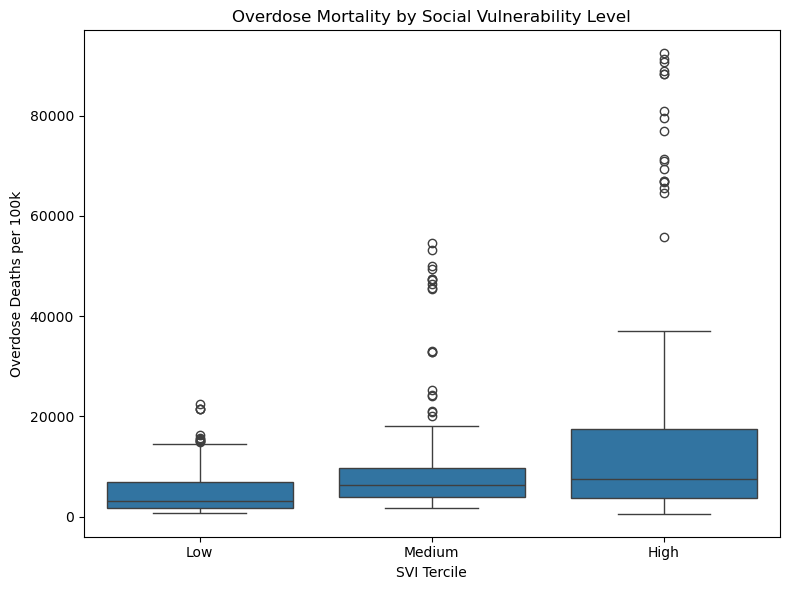

In [39]:
df_final["SVI_Tercile"] = pd.qcut(df_final["SVI_IndexScore"], q=3, labels=["Low", "Medium", "High"])

plt.figure(figsize=(8,6))
sns.boxplot(x="SVI_Tercile", y="OverdoseRatePer100k", data=df_final)
plt.title("Overdose Mortality by Social Vulnerability Level")
plt.xlabel("SVI Tercile")
plt.ylabel("Overdose Deaths per 100k")
plt.tight_layout()
plt.savefig('boxplot_svi_overdose.png', format='png')
plt.show()

# Line plot overdose trends over time by region


C:\Users\Pablo\AppData\Local\Temp\ipykernel_18492\3512687108.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_over_time = df_final.groupby(["Year", "SVI_Tercile"]).agg({"OverdoseRatePer100k": "mean"}).reset_index()


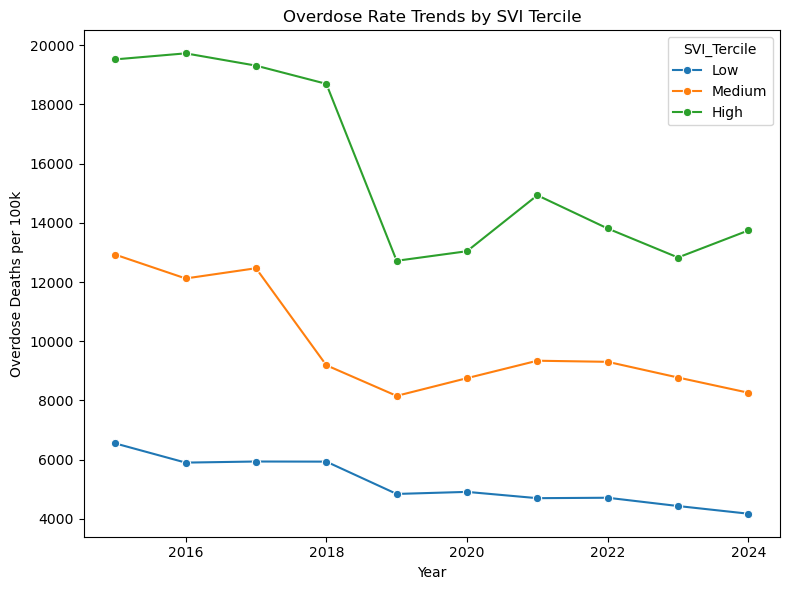

In [41]:
avg_over_time = df_final.groupby(["Year", "SVI_Tercile"]).agg({"OverdoseRatePer100k": "mean"}).reset_index()

plt.figure(figsize=(8,6))
sns.lineplot(data=avg_over_time, x="Year", y="OverdoseRatePer100k", hue="SVI_Tercile", marker="o")
plt.title("Overdose Rate Trends by SVI Tercile")
plt.ylabel("Overdose Deaths per 100k")
plt.xlabel("Year")
plt.tight_layout()
plt.savefig('lineplot_trends_by_svi.png', format='png')
plt.show()

# Heatmap: Poverty x Insurance vs Overdose

C:\Users\Pablo\AppData\Local\Temp\ipykernel_18492\2127671667.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = df_final.groupby(["Poverty_bin", "Uninsured_bin"])["OverdoseRatePer100k"].mean().unstack()


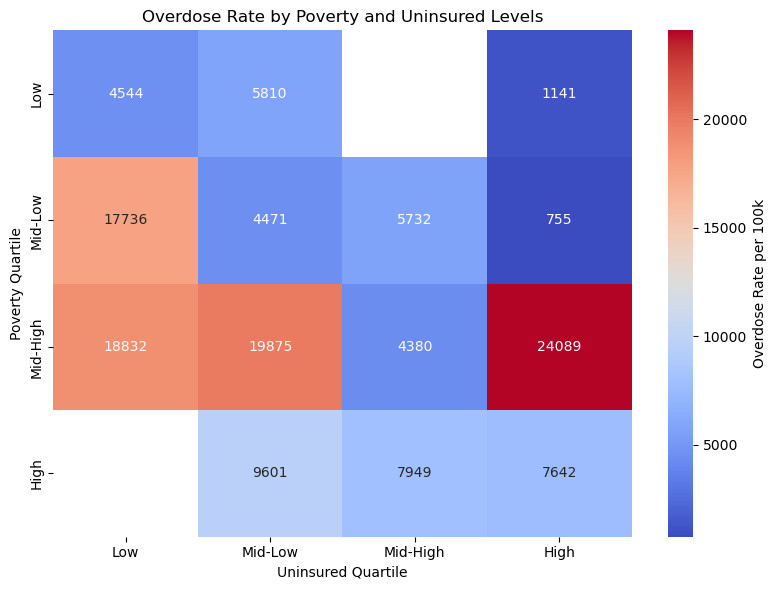

In [63]:
quartile_labels = ['Low', 'Mid-Low', 'Mid-High', 'High']

df_final["Poverty_bin"] = pd.qcut(df_final["PercentBelow150Poverty"], q=4, labels=quartile_labels)
df_final["Uninsured_bin"] = pd.qcut(df_final["PercentUninsured"], q=4, labels=quartile_labels)

heatmap_data = df_final.groupby(["Poverty_bin", "Uninsured_bin"])["OverdoseRatePer100k"].mean().unstack()
mask = heatmap_data.isnull()
# heatmap_data = heatmap_data.fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="coolwarm", cbar_kws={'label': 'Overdose Rate per 100k'})
plt.title("Overdose Rate by Poverty and Uninsured Levels")
plt.xlabel("Uninsured Quartile")
plt.ylabel("Poverty Quartile")
plt.tight_layout()
plt.savefig('heatmap_poverty_uninsured_overdose.png', format='png')
plt.show()

# Coefficient Plot Early Regression

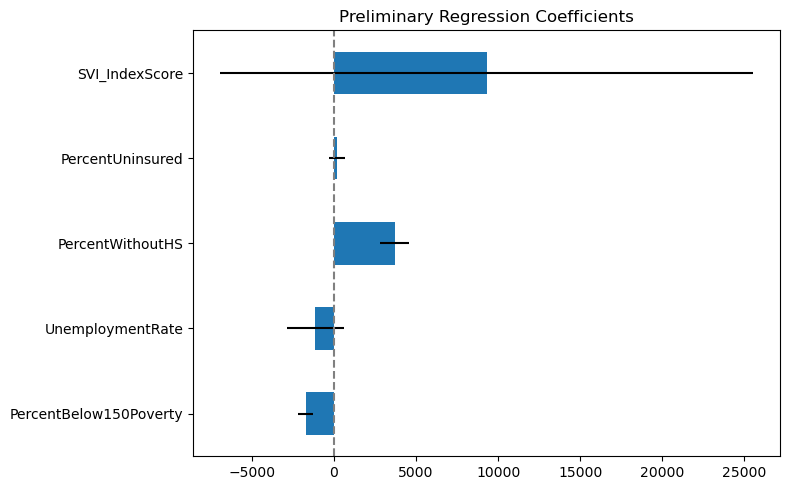

In [45]:

X = df_final[["PercentBelow150Poverty", "UnemploymentRate", "PercentWithoutHS", "PercentUninsured", "SVI_IndexScore"]]
y = df_final["OverdoseRatePer100k"]

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

coef_df = model.conf_int()
coef_df.columns = ["LowerCI", "UpperCI"]
coef_df["Coef"] = model.params
coef_df = coef_df.drop("const")

plt.figure(figsize=(8,5))
coef_df["Coef"].plot(kind='barh', xerr=(coef_df["UpperCI"] - coef_df["LowerCI"])/2)
plt.axvline(0, color='gray', linestyle='--')
plt.title("Preliminary Regression Coefficients")
plt.tight_layout()
plt.savefig('coef_plot_early_model.png', format='png')
plt.show()
